# Creating a mind map before getting into action

So after coming across from the mistakes before this notebook, let's plan what all things we need to do so that we perform the crucial steps needed for the NMT to make with all the proper components and the preprocessed data.

**Data Preprocessing Actions**:
1. Shift the target texts.
2. Pad the text with proper annotations.

**Components of the model**:
1. Create *text vectors* of both source and target language separately using TensorFlow `TextVectorization` layer.
2. Create *embedding layers* of both source and target language separately using TensorFlow `Embedding` layer.
3. Create a class known *Encoder* which inherits the properties of TensorFlow class `Layer`. In the sub-class method of creating a layer, we are going to develop the encoder architecture of the NMT. (The architecture will be discussed while we are developing the layer.)
4. Create a class known as *Decoder* which inherits the properties of TensorFlow class `Layer`. In this sub-class method of creating a layer, we are going to develop the decoder architecture of the NMT. (The architecture will be discussed while we are developing the layer.)
5. After creating all the components, we are going to create a class called *EncoderDecoder* which will inherit from TensorFlow class `Model`. In this class we will assemble all of the layers that we have prepared in the above steps and then create a custom call function which will allow us to train the decoder layer as we expect it to do.
6. Create an instance of the *EncoderDecoder* class with all the parameters passed in its constructor and compile the model with `tf.keras.losses.SparseCategoricalCrossentropy()` as loss function and `tf.keras.optimizers.RMSprop()` as the optimizer.
7. We will then create the *train_dataset* and *valid_dataset* using TensorFlow `tf.data` API for better performance of the model training.
8. We will fit the model with the training data with 5 epochs and *callbacks* such as `tf.keras.callbacks.ModelCheckPoint`, `tf.keras.callbacks.EarlyStopping`, `tf.keras.callbacks.ReduceLROnPlateau` and the validation dataset.
9. After training the model we will evaluate the model using different metrics system and predict with an unseen data and observe the quality of the prediction.

# Importing all the necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tarfile
import random

# Start the project

As all machine learning project has two phases, this is project is no exception for it. We will first work on the *Data Preprocessing* and then *Model Development*

## Data Preprocessing

In [2]:
# Creating a constant which contains the starting path of the project so that
START_PATH = str(os.getcwd()) + '/'
COMP_DATA_PATH = os.path.join(START_PATH, 'wiki-titles.tgz')
DATA_URL = 'https://www.statmt.org/wmt14/wiki-titles.tgz'
DATA_DIR = os.path.join(START_PATH, 'wiki/hi-en/wiki-titles.hi-en')

### Loading Data

In [3]:
if not os.path.exists(COMP_DATA_PATH):
    print(f'Downloading data from {DATA_URL}')
    !wget https://www.statmt.org/wmt14/wiki-titles.tgz
else:
    print("Data already downloaded")

Data already downloaded


In [4]:
if not os.path.exists(COMP_DATA_PATH):
    print("File does not exist")
else:
    print("The file exists")

The file exists


In [5]:
with tarfile.open(COMP_DATA_PATH, 'r') as tar_ref:
    tar_ref.extractall()
    print("File extracted")

File extracted


### Extracting data from file 

In [6]:
# Extracting the lines from the file of the dataset
with open(DATA_DIR, 'r') as f:
    lines = f.readlines()

In [7]:
# Splitting the data into two list of source language and target language
src_senteces = [line.split('|||')[1][1:-1] for line in lines]
trg_sentences = [line.split('|||')[0][:-1] for line in lines]
src_senteces[:10], trg_sentences[:10], len(src_senteces), len(trg_sentences)

(['January 0',
  'March 0',
  '1000',
  '1001',
  '1002',
  '1003',
  '1004',
  '1005',
  '1006',
  '1007'],
 ['० जनवरी',
  '० मार्च',
  '१०००',
  '१००१',
  '१००२',
  '१००३',
  '१००४',
  '१००५',
  '१००६',
  '१००७'],
 32863,
 32863)

### Visualise the data

In [8]:
def visualise_random_sentences(src_sent, trg_sent):    
    random_idx = random.randint(0, len(src_sent))
    
    print(f"Source sentence: {src_sent[random_idx]}")
    print(f"Target sentence: {trg_sent[random_idx]}")
    
visualise_random_sentences(src_sent= src_senteces,
                    trg_sent= trg_sentences)

Source sentence: Flag of Transnistria
Target sentence: ट्राँस्निस्ट्रिया का ध्वज


### Shift the target data with one token

In [9]:
trg_sentences_preprocessed = ['<SOS> ' + sentence + ' <EOS>' for sentence in trg_sentences]
visualise_random_sentences(src_sent= src_senteces,
                           trg_sent= trg_sentences_preprocessed)

Source sentence: Pooja Bhatt
Target sentence: <SOS> पूजा भट्ट <EOS>


In [10]:
# Calculate the max length of the text for each language lists
src_word_per_sentence = [len(line.split()) for line in src_senteces]
trg_word_per_sentence = [len(line.split()) for line in trg_sentences_preprocessed]

max_src_len = max(src_word_per_sentence)
max_trg_len = max(trg_word_per_sentence)

print(f"Max source sentence length: {max_src_len}")
print(f"Max target sentence length: {max_trg_len}")

Max source sentence length: 13
Max target sentence length: 17


In [11]:
# Storing vocab
src_vocab, trg_vocab = set(), set()
for sentence in src_senteces:
    for word in sentence.split():
        src_vocab.add(word)
        
for sentence in trg_sentences:
    for word in sentence.split():
        trg_vocab.add(word)
        
len(src_vocab), len(trg_vocab)

(28851, 29073)

In [12]:
# Splitting the data into train and test
src_train, src_test, trg_train, trg_test = train_test_split(src_senteces, trg_sentences_preprocessed, test_size=0.2, random_state= 42)

len(src_train), len(trg_train), len(src_test), len(trg_test)

(26290, 26290, 6573, 6573)

>**Note**: Padding of the data will be done after vectorising the text data

## Model development

We have completed the data preprocessing of the data and are ready to develop the model. Let's discuss the steps we are going to take for it:
1. Create individual components
2. Assemble the model
3. Create Data Pipeline
4. Fit the model
5. Evaluate the model
6. Predict using the model

### Creating Components

Before starting with the model, first we need to create some building blocks for the Encoder Decoder archtiecture of NMT. The components that we are going to make here are:
1. Encode layer:
        * *Inheritance*: `tf.keras.layers.Layer`
        * *Constructor Input*: 
        * *Call function Input*: src_sentences
        * *Return*: Encoder output, RNN layer states
2. Decoder layer:
        * *Inheritance*: `tf.keras.layers.Layer`
        * *Constructor Input*: 
        * *Call function Input*: trg_sentences_preprocessed, context, encoder_states
        * *Return*: RNN output

In [13]:
# Creation of Encoder layer class
class Encoder(tf.keras.layers.Layer):
    '''
    This class creates a custom encoder layer based on the Google's research paper of NMT.
    For more reference please view https://arxiv.org/pdf/1609.08144.pdf%20(7
    
    This class is an inheritied class from `tf.keras.layers.Layer`. In this class, we will create the constructor
    of the encoder layer and then define the call function so that we can set the working of the encoder layer using 
    Functional API.
    '''
    
    def __init__(self, units: int, dropout_rate: float, num_layers: int, **kwargs):
        '''
        Constructs the encoder
        
        Parameters:
            units: Nuumber of neurons required per LSTM layer
            dropout_rate: to set the dropout rate
            num_layers: to set the number of encoding layer
        Returns:
            An instance of Encoder class which works as the encoder described in the research paper
        '''
        
        # calling the super method to initialise
        super().__init__(**kwargs)
        
        # initialising all the object variables
        self.units = units
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers
        
        # initialise the layers
        self.bi_lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units= self.units // 2,
                                                                                return_sequences=True,
                                                                                dropout=self.dropout_rate),
                                                           name= 'encoder_bi_lstm_layer')
        
        self.lstm_recurrent_layers = []
        for i in range(self.num_layers - 1):
            self.lstm_recurrent_layers.append(tf.keras.layers.LSTM(units= self.units,
                                                         return_sequences=True,
                                                         return_state=True,
                                                         dropout=self.dropout_rate,
                                                         name= f'encoder_lstm_recurrent_layer_{i + 1}'))
        self.add_layer = tf.keras.layers.Add()
    
    def call(self, inputs):
        x = self.bi_lstm_layer(inputs)
        x, h, c = self.lstm_recurrent_layers[0](x)
        x = self.add_layer([x, h, c])
        for layer in self.lstm_recurrent_layers:
            x, h, c = layer(x)
            x = self.add_layer([x, h, c])
        
        return x, h, c
    
encoder_layer = Encoder(units= 512, 
                        dropout_rate= 0.5,
                        name= 'encoder_layer',
                        num_layers= 8)
encoder_layer.get_config()

{'name': 'encoder_layer',
 'units': 512,
 'dropout_rate': 0.5,
 'num_layers': 8,
 'trainable': True,
 'dtype': 'float32'}

In [14]:
# Checking the functionality of the layer using dummy values
encoder_output, encoder_hidden, encoder_carry = encoder_layer(tf.random.uniform(shape=(10, 17, 128)))
encoder_output.shape, encoder_hidden.shape, encoder_carry.shape

(TensorShape([10, 17, 512]), TensorShape([10, 512]), TensorShape([10, 512]))

In [28]:
# Create Decoder class
class Decoder(tf.keras.layers.Layer):
    '''
    This class creates is for an instance of Decoder layer. This inherits the properties of `tf.keras.layers.Layer`.
    We are going to create the constructor and the call function which will contain the Functional API structure
    of computing the values which is the input.
    
    This layer is refered from the above mentioned paper.
    '''
    
    def __init__(self, units: int, num_layers: int, dropout_rate: float, **kwargs):
        '''
        Constructor of the decoder class which helps initialize the variables and create the layer
        Parameters:
            units: number of neurons in the LSTM layer
            num_layers: number of layers expected in the decoder layer
            embedding_size: to set the input value of the layer
            dropout_rate: to set the dropout rate of the LSTM layer
            
        Returns:
            An instance of the decoder class which will act as a layer
        '''
        
        # calling the super function
        super().__init__(**kwargs)
        
        # initialising all the variables
        self.units = units
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.encoder_layer = encoder_layer
        
        # initialising the layers
        # self.lstm_cell = tf.keras.layers.LSTMCell(units= self.units,
        #                                           name= 'decoder_lstm_cell')
        self.lstm_layers = []
        for i in range(self.num_layers):
            self.lstm_layers.append(tf.keras.layers.LSTM(units= self.units,
                                                          return_sequences=True,
                                                         return_state=True,
                                                         dropout=self.dropout_rate,
                                                          name= f'decoder_lstm_layer_{i}'))
            self.add_layer = tf.keras.layers.Add()
            self.attention_layer = tf.keras.layers.Attention()
    
    def call(self, inputs, encoder_output):
        x, _, _ = self.lstm_layers[0](inputs)
        x = self.attention_layer([x, encoder_output])
        # print(context.shape)
        x, h, c = self.lstm_layers[1](x)
        x = self.add_layer([x, h, c])
        for layer in self.lstm_layers[2:]:
            x, h, c = layer(x)
            x = self.add_layer([x, h, c])
        
        
        return  x
        
decoder_layer = Decoder(units= 512,
                        num_layers= 8,
                        dropout_rate= 0.5)
decoder_layer.get_config()     

{'name': 'decoder_1',
 'units': 512,
 'num_layers': 8,
 'dropout_rate': 0.5,
 'trainable': True,
 'dtype': 'float32'}

In [30]:
# Testing decoder layer
decoder_output = decoder_layer(tf.random.uniform(shape= (10, 17, 128)), encoder_output= encoder_output)
print(decoder_output.shape)

(10, 17, 512)


### Assemble Components into Model

We have created the components that we require for the Encoder Decoder NMT. The components are as follows:
1. Encoder layer
2. Decoder layer with attention layer

Now in the below cell we are going to assemble all the parts in this order:
1. Source input layer
2. Source Text Vectorizer layer
3. Source Embedding layer
4. Encoder layer
5. Target input layer
6. Target Text Vectorizer layer
7. Target Embedding layer
8. Decoder layer
9. Final dense softmax layer with target vocab size as output

In [48]:
# Creating Text Vectorizer layer
src_text_vectorizer_layer = tf.keras.layers.TextVectorization(max_tokens= len(src_vocab),
                                                            pad_to_max_tokens= True,
                                                            output_sequence_length= max(max_src_len, max_trg_len),
                                                              name= 'src_text_vectorization_layer')
trg_text_vectorizer_layer = tf.keras.layers.TextVectorization(max_tokens= len(trg_vocab),
                                                            pad_to_max_tokens= True,
                                                            output_sequence_length= max(max_trg_len, max_src_len),
                                                              name= 'trg_text_vectorization_layer')

# Adapting the vectorizer
src_text_vectorizer_layer.adapt(src_train)
trg_text_vectorizer_layer.adapt(trg_train)

In [49]:
# Testing the text vectorizer
random_idx = random.randint(0, len(src_train))

print(f"Src Text: {src_train[random_idx]}")
print(f"Src Vector: {src_text_vectorizer_layer(src_train[random_idx])}")
print(f"Trg Text: {trg_train[random_idx]}")
print(f"Trg Vector: {trg_text_vectorizer_layer(trg_train[random_idx])}")

Src Text: Varkala
Src Vector: [6955    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]
Trg Text: <SOS> वर्कला <EOS>
Trg Vector: [    2 10637     3     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]


In [50]:
# Creating constants for the model parameters
E_UNITS = 512
E_NUM_LAYERS= 8
E_DROPOUT_RATE = 0.5
D_UNITS = 512
D_NUM_LAYERS= 8
D_DROPOUT_RATE = 0.5

In [51]:
# Creating model using Functional API

# Creating the inputs
src_inputs = tf.keras.layers.Input(shape=(1, ), dtype= 'string', name= 'src_inputs')
trg_inputs = tf.keras.layers.Input(shape=(1, ), dtype= 'string', name= 'trg_inputs')

# Creating text vectorization and embedding connection
src_embedding= tf.keras.layers.Embedding(input_dim= len(src_vocab),
                                         output_dim= 128,
                                         name= 'src_embedding')(src_text_vectorizer_layer(src_inputs))
trg_embedding= tf.keras.layers.Embedding(input_dim= len(trg_vocab),
                                         output_dim= 128,
                                         name= 'trg_embedding')(trg_text_vectorizer_layer(trg_inputs))

# Creating Encoder instnace and its connection with the src_input
encoder_layer = Encoder(units= E_UNITS,
                        dropout_rate= E_DROPOUT_RATE,
                        num_layers= E_NUM_LAYERS,
                        name= 'encoder_layer')
encoder_output, encoder_hidden, encoder_carry = encoder_layer(src_embedding)

# Creating Decoder instance and its connecton with both trg_input and encoder_output
decoder_layer = Decoder(units= D_UNITS,
                        dropout_rate= D_DROPOUT_RATE,
                        num_layers= D_NUM_LAYERS,
                        name= 'decoder_layer')
decoder_output = decoder_layer(trg_embedding, encoder_output= encoder_output)

# Creating the final dense layer connection to predict the output
final_output = tf.keras.layers.Dense(len(trg_vocab), activation= 'softmax', name= 'final_output')(decoder_output)

model = tf.keras.models.Model(inputs= [src_inputs, trg_inputs], 
                              outputs= final_output,
                              name= 'EncoderDecoderNMT')

model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.RMSprop(learning_rate= 1e-4))

model.summary()

/Users/klsharma22/PycharmProjects/EncoderDecoderExp/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'decoder_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "EncoderDecoderNMT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ src_inputs          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trg_inputs          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ src_text_vectoriza… │ (None, 17)        │          0 │ src_inputs[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trg_text_vectoriza… │ (None, 17)        │          0 │ trg_inputs[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ src_embedding       │ (None, 17, 128)   │  3,692,928 │ src_text_vectori… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trg_embedding       │ (None, 17, 128)   │  3,721,344 │ trg_text_vectori… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer       │ [(None, 17, 512), │ 15,482,880 │ src_embedding[0]… │
│ (Encoder)           │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer       │ (None, 17, 512)   │ 31,490,048 │ trg_embedding[0]… │
│ (Decoder)           │                   │            │ encoder_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 17, 29073) │ 14,914,449 │ decoder_layer[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,818,769 (205.30 MB)

 Trainable params: 53,818,769 (205.30 MB)

 Non-trainable params: 0 (0.00 B)

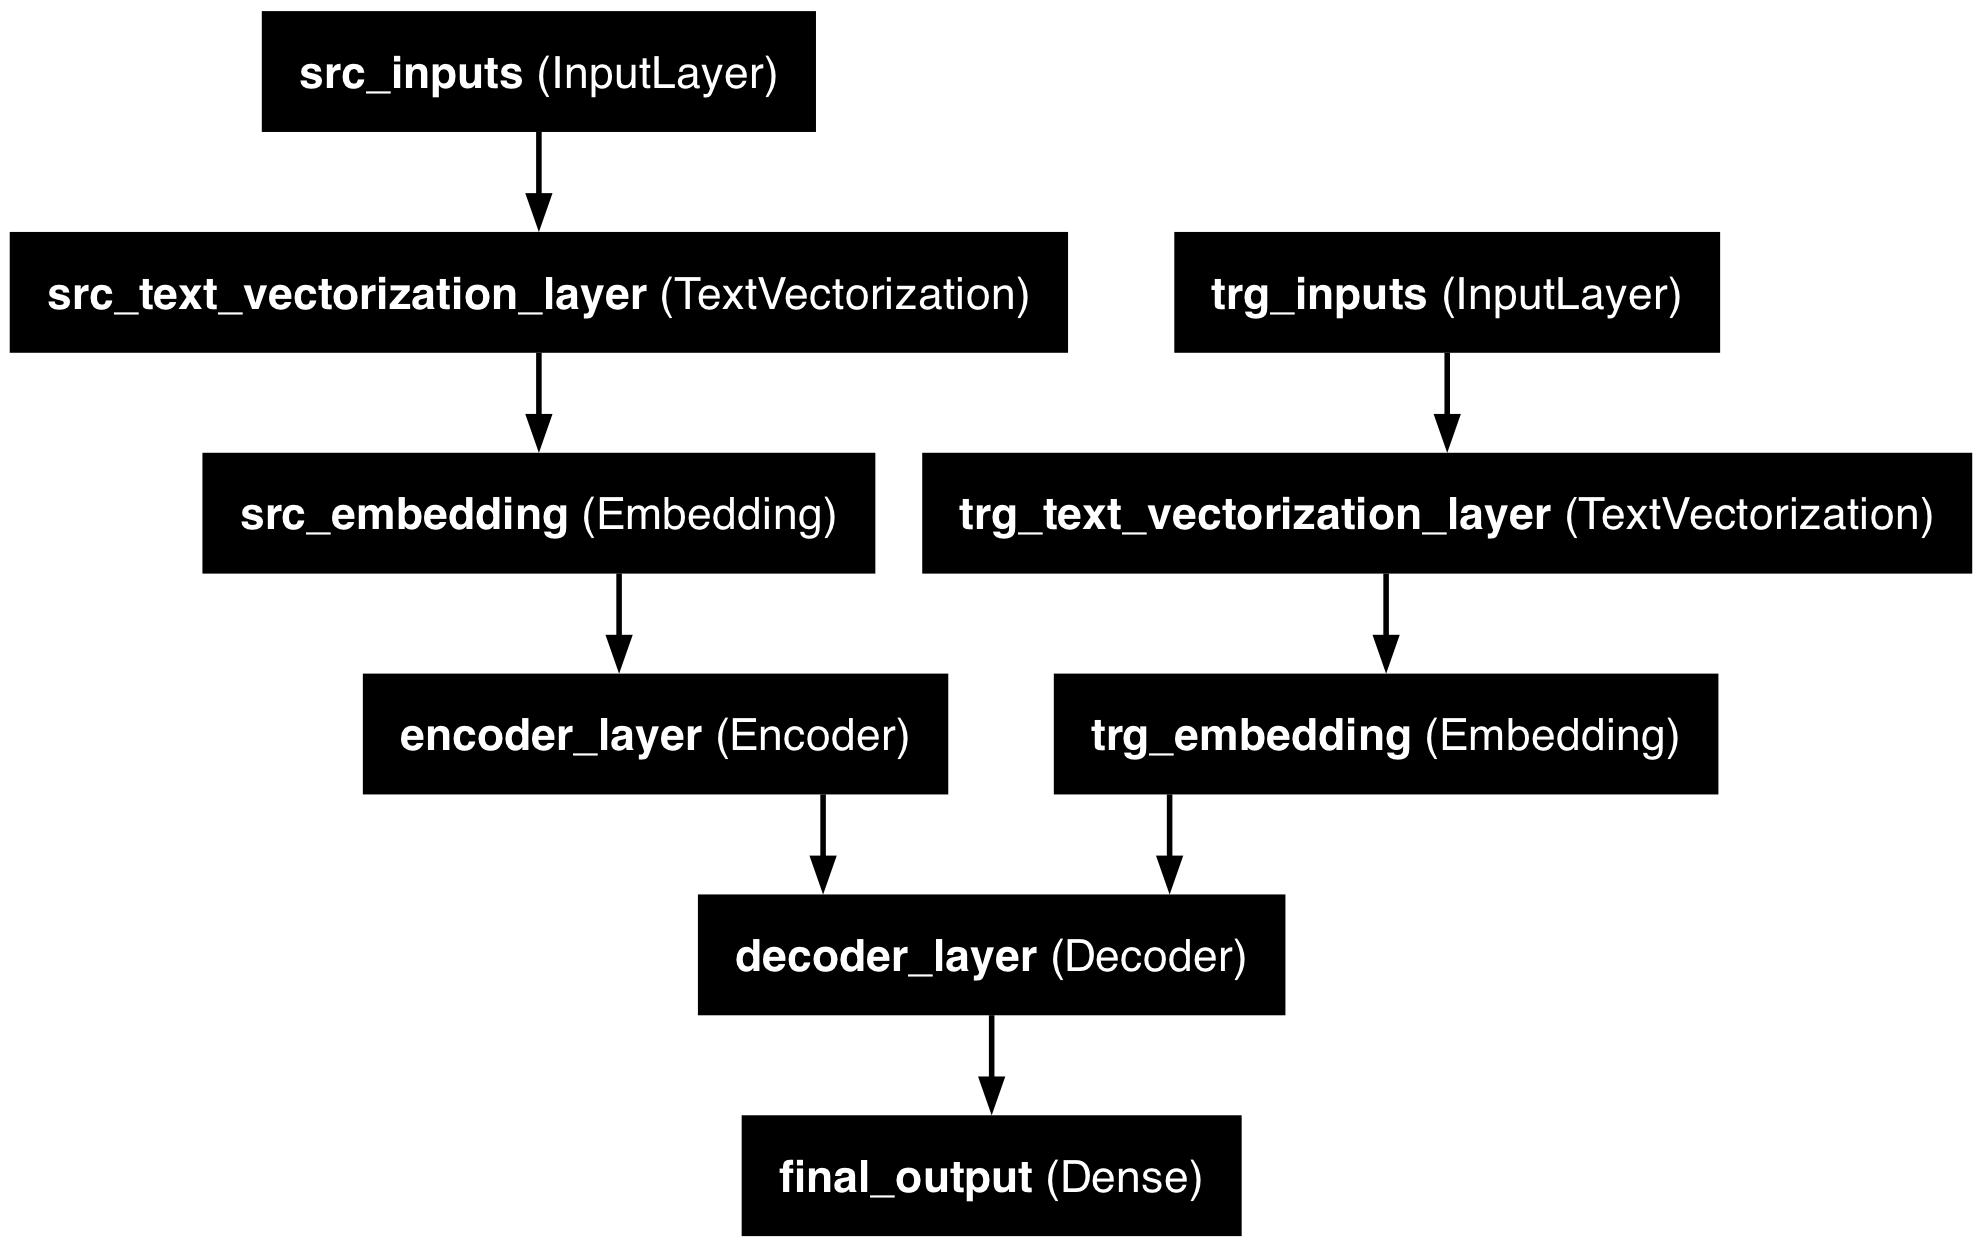

In [52]:
tf.keras.utils.plot_model(model, show_layer_names= True)

### Create Data Pipeline

Our model has been created with all the components being connected with each other. Now our next agenda is to create a smooth data pipeline using `tf.data` API which will help us create a prefetch data which will utilise both CPU and GPU for data handling during model training. This will give us an advantage over the performance of the model.

### Fit the model

### Evaluate model Performance

### Making Predictions using the best model trained